In [139]:
import sys
sys.path.append('../')
from src.dataset import read_folder
from src.landmarks import Landmarks
from src.visualization import plot_landmarks_color
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries, slic

In [2]:
PATH = '../LaPa/examples'

In [3]:
images = read_folder(PATH, n = None, landmarks= 'landmarks', RGB = True)

In [4]:
# At the beginning, lets find face landmarks (focusing on the contour)

In [465]:
import dlib
from imutils import face_utils
from scipy.spatial import ConvexHull
import collections
import pandas as pd
import seaborn as sns

In [6]:
from src.visualization import plot_img, plot_hist_with_component

In [360]:
from ipynb.fs.defs.skinDetection import avg_color, plot_diffrent_color_palette_with_components, simple_tresholding
from ipynb.fs.defs.skinDetection import calculate_img_avg_by_channel, measure

In [8]:
sys.path.append('../FaceLandmarks')
#%cd ../FaceLandmarks

In [9]:
#import ipynb.fs.defs.faceLandmarks

In [12]:
import import_ipynb
import FaceLandmarks.faceLandmarks as faceLandmarks

In [13]:
def face_detec_plot(img, rects, ax = plt):
    ax.imshow(img)
    ax.plot([rects[0].bottom(), rects[0].bottom(), rects[0].top(), rects[0].top(), rects[0].bottom()], 
             [rects[0].right(),rects[0].left(), rects[0].left(), rects[0].right(), rects[0].right()])
    ax.axis('off')

In [14]:
def detect_face(DETECTOR, gray, img = None, plot = True):
    rects = DETECTOR(gray, 1)
    if plot:
        if len(rects) == 0: 
            raise ValueError("Ops! Face has not been detected", rects)
        else:
            face_detec_plot(img, rects)
    return rects

In [15]:
def face_predict_landmarks(gray, rect, PREDICTOR):
    """predict face landmarks using PREDICTOR dlib's object,
    rects is the bounding box to begin the shape prediction inside. """
    landmarks = PREDICTOR(gray, rect) # http://dlib.net/python/index.html#dlib.shape_predictor (__call__ method)
    landmarks = face_utils.shape_to_np(landmarks)
    
    # now let's return object Landmarks, Class Landmarks is defined in src/landmarks.py file, 
    # more about it you can find in notebook: /MeetDataset/meetDataset.ipynb
    return Landmarks(landmarks) 

In [16]:
DETECTOR = dlib.get_frontal_face_detector() #the default face detector
PREDICTOR = dlib.shape_predictor("../FaceLandmarks/shape_predictor_68_face_landmarks.dat")

In [17]:
example_img = list(images.keys())[6]
img_RGB = images[example_img]['img']
gray = cv2.cvtColor(img_RGB, cv2.COLOR_RGB2GRAY)

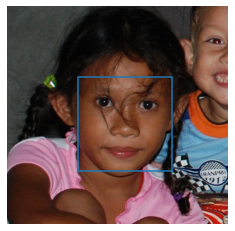

In [18]:
rects = detect_face(DETECTOR, gray, img_RGB)

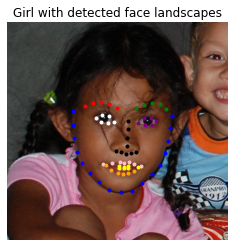

In [19]:
landmarks = face_predict_landmarks(gray, rects[0], PREDICTOR)
plot_img(img_RGB)
plot_landmarks_color(landmarks)
plt.title('Girl with detected face landscapes')
plt.show()

In [20]:
x = landmarks()[:,0]
y = landmarks()[:,1]

hight = max(y) - min(y)

new_rect = dlib.rectangle(max(y), min(x), max(min(y) - hight//2,0), max(x))

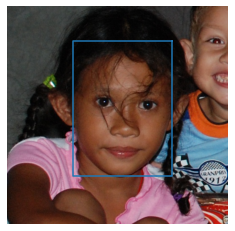

In [21]:
face_detec_plot(img_RGB, [new_rect])

In [22]:
landmarks.points_info['CONTOURS']

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

In [23]:
def find_mask_from_landmarks(img, landmarks, full_mask = True, plot = True):
    contours = np.take(landmarks(), landmarks.points_info['CONTOURS'], axis = 0)
    img_mask = np.zeros_like(img) # create a single channel 200x200 pixel black image 
    cv2.fillPoly(img_mask, pts =[contours], color=(255,255,255))
    if full_mask == False:
        
        l_eye = np.take(landmarks(), landmarks.points_info['LEFT_EYE'], axis = 0)
        r_eye = np.take(landmarks(), landmarks.points_info['REIGHT_EYE'], axis = 0)
        
        nose = np.take(landmarks(), landmarks.points_info['NOSE_POINTS'], axis = 0)
        hull = ConvexHull(nose)
        nose = nose[hull.vertices]
        lips = np.take(landmarks(), landmarks.points_info['UPPER_LIP'] + landmarks.points_info['BOTTOM_LIP'], axis = 0)
        
        for i in [l_eye, r_eye , nose, lips]:
            cv2.fillPoly(img_mask, pts =[i], color=(0,0,0))     
        
    if plot:
        plot_img(img_mask, alpha = 0.5)
    return img_mask, contours

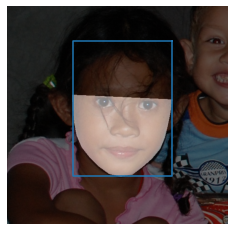

In [24]:
face_detec_plot(img_RGB, [new_rect])
_ = find_mask_from_landmarks(img_RGB, landmarks)

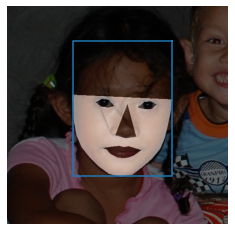

In [25]:
face_detec_plot(img_RGB, [new_rect])
img_mask, contours = find_mask_from_landmarks(img_RGB, landmarks, False)

In [26]:
# Let's play with diffrent color pallete.

In [27]:
img_BGR = cv2.cvtColor(img_RGB, cv2.COLOR_RGB2BGR)

In [28]:
img_YCrCb = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2YCrCb)

In [29]:
# And check avg color for img_YCrCb, where mask created using landmarks equal 255.
# We have arleady done something similar in skinDetection.ipynb, hence we can use calculate_img_avg_by_channel function
avg_face_YCrCb = calculate_img_avg_by_channel(img_YCrCb, img_mask[:,:,0]==255)
avg_face_YCrCb

(83.25850408129268, 155.1006829918374, 108.34702648675662)

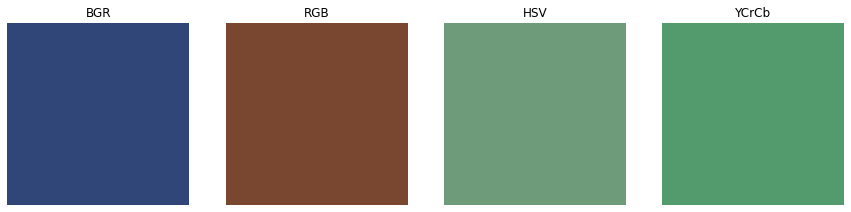

In [30]:
# we can also use avg_color function from skinDetection.ipynb to check avg color for each color pallete
avgs = avg_color(img_BGR,  img_mask[:,:,0] == 255)

In [31]:
# of course avg_face_YCrCb is equal 4th value of avgs
avgs

[(48.42768615692154, 70.66186906546727, 121.20029985007496),
 (121.20029985007496, 70.66186906546727, 48.42768615692154),
 (110.91007829418623, 155.52293853073462, 121.20782941862402),
 (83.25850408129268, 155.1006829918374, 108.34702648675662)]

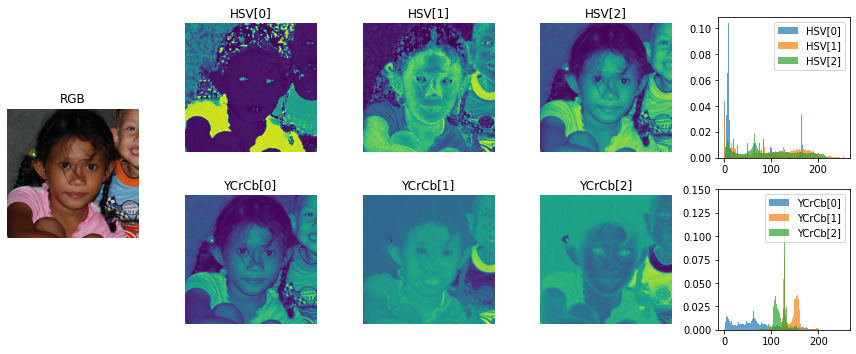

In [32]:
# Let's plot again histogram and each components from HSV and YCrCB
plot_diffrent_color_palette_with_components(img_BGR)

In [33]:
# let's focous only for 2nd component of YCrCb
component = img_YCrCb[:,:,2]

In [381]:
def create_masks(component, treshold_range_mean, treshold_range_var, mask_from_landmarks, landmarks):
    
    # get infomatation about landmarks positions
    x = landmarks()[:,0]
    y = landmarks()[:,1]
    hight = max(y) - min(y)

    # create treshold_range, that avg will be avg calcualted using mask created using landmarks, and variance will be 10. 
    treshold_range = [avg_face_YCrCb[2] - treshold_range_var, avg_face_YCrCb[2] + treshold_range_var]

    # create skin mask using treshold_range
    mask_created_via_treshold = (cv2.inRange(component, * treshold_range)).astype(int)
    mask_created_via_treshold = np.tile(mask_created_via_treshold[:,:,None], [1,1, 3])

    # create new mask where base will be mask created using landmarks
    mask_from_landmarks_and_roi = mask_from_landmarks.copy()

    # we would like to find first and last landmarsk to create some kind of line where 
    # under the line there will definitely be a mask made of dots. and we do not know the upper limit.

    first = landmarks.points_info['CONTOURS'][0]
    last = landmarks.points_info['CONTOURS'][-1]

    i = np.array([[x[first],y[last]],
                                [x[last],y[last]],
                                 [x[last], max(min(y) - hight//2,0)],
                                [x[first], max(min(y) - hight//2,0)]])

    # Fill upper part of ROI as potential mask 
    _ = cv2.fillPoly(mask_from_landmarks_and_roi, pts = [i], color=(255,255,255)) 

    # concatenate all mask -- check where skin has been detected on potential mask 
    final_mask = ((mask_created_via_treshold == [255,255,255]) & 
                             (mask_created_via_treshold==mask_from_landmarks_and_roi)).astype(int)*255
    
    return mask_from_landmarks_and_roi, mask_created_via_treshold, final_mask, treshold_range

In [35]:
mask_from_landmarks_and_roi, mask_created_via_treshold, final_mask, treshold_range = create_masks(component = component,
                                                                                  treshold_range_mean = avg_face_YCrCb[2],
                                                                                  treshold_range_var = 10, 
                                                                                  mask_from_landmarks = img_mask, 
                                                                                  landmarks = landmarks)

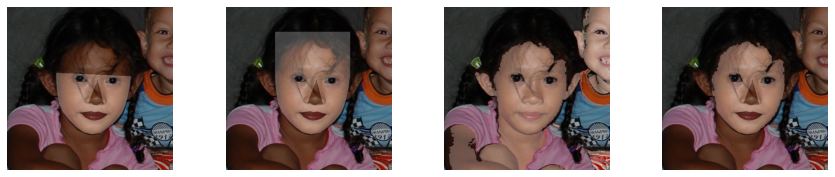

In [36]:
f, axs = plt.subplots(1,4, figsize=(15,3))

# plot example image
plot_img(img_RGB, ax = axs[0])
plot_img(img_mask, alpha = 0.25, ax = axs[0])

# plot example image with potential mask
plot_img(img_RGB, ax = axs[1])
plot_img(mask_from_landmarks_and_roi, alpha = 0.25, ax = axs[1])

# plot example image with skin mask
plot_img(img_RGB, ax = axs[2])
plot_img(mask_created_via_treshold, alpha = 0.25, ax = axs[2])

# plot example image with final mask
plot_img(img_RGB, ax = axs[3])
plot_img(final_mask, alpha = 0.25, ax = axs[3])

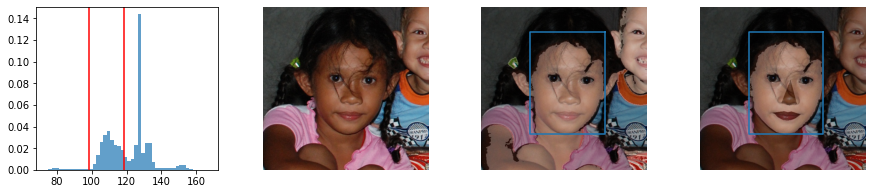

In [37]:
f, axs = plt.subplots(1,4, figsize=(15,3))

# plot histogram of 2nd component of YCrCb with treshold_range2 
plot_hist_with_component(component, axs[0])
axs[0].axvline(x=treshold_range[0], color = 'r')
axs[0].axvline(x=treshold_range[1], color = 'r')

# plot example image
plot_img(img_RGB, ax = axs[1])

# plot image with rectangle (ROI), where the whole face should be 
face_detec_plot(img_RGB, [new_rect], axs[2])
# plot mask where skin has been detected
plot_img(mask_created_via_treshold, alpha = 0.25, ax = axs[2])


face_detec_plot(img_RGB, [new_rect], axs[3])
plot_img(final_mask, alpha = 0.25, ax = axs[3])

In [38]:
# define Path 
PATH = '../LaPa/train'
# load examples, BGR, with labels
images_train = read_folder(PATH, n = 1000, labels = 'labels')

In [375]:
def find_final_mask(img_BGR, treshold_range_var = 10):
    # change img to gray
    gray = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2GRAY)

    # detect face in the picture
    rects = detect_face(DETECTOR, gray, plot = False)
    if len(rects) != 0:

        # detect landmarks
        landmarks = face_predict_landmarks(gray, rects[0], PREDICTOR)

        # create mask using landmarks
        img_mask, contours = find_mask_from_landmarks(img_BGR, landmarks, False, False)

        # create YCrCb image 
        img_YCrCb = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2YCrCb)

        # calculate avage YCrCb image where img is covered by mask
        avg_face_YCrCb = calculate_img_avg_by_channel(img_YCrCb, img_mask[:,:,0]==255)

        # create mask
        _, _, final_mask, _ = create_masks(component = img_YCrCb[:,:, 2],
                                          treshold_range_mean = avg_face_YCrCb[2],
                                          treshold_range_var = treshold_range_var, 
                                          mask_from_landmarks = img_mask, 
                                          landmarks = landmarks)
        
        final_mask = np.where(final_mask == [255, 255, 255], final_mask, img_mask)
        return img_mask, final_mask, img_YCrCb, landmarks
    
    return None, None, None, None

In [448]:
example_img = list(images_train.keys())[5]
img_BGR = images_train[example_img]['img']
img_RGB = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2RGB)
img_mask, final_mask, img_YCrCb, landmarks = find_final_mask(img_BGR)

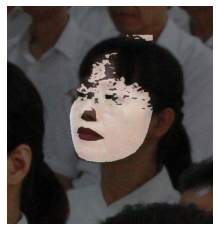

In [386]:
plot_img(img_RGB)
plot_img(final_mask, alpha = 0.5)

first, notice that this bonnet has a lot of clearances. Therefore one way to help/improve result is using the closure morphological operations. 
But there is also one more problem. Can you see small part of neck above women's hair? We should ignore it, at least I can imagine there could be a case of a bald person who would wear a headband. However, in this tutorial we will not consider such cases.

We can find how many components are connected using `connectedComponentsWithStats` function

In [387]:
final_mask_unit8 = np.uint8(final_mask[:,:,0])

In [388]:
output = cv2.connectedComponentsWithStats(final_mask_unit8)
(numLabels, labels, stats, centroids) = output

In [389]:
# In this case we have 13 separated compontents! 
numLabels

13

It is true that the segments are very small. The interesting segments are: background, face, neck of another person.

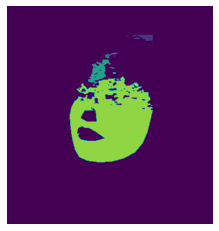

In [390]:
plot_img(labels)

In [391]:
# Let's check how many pixels are inclueded in each segments:
segments = dict(collections.Counter(labels.flatten()))
segments_sorted = dict(sorted(segments.items(), key=lambda x:x[1], reverse = True))
segments_sorted

{0: 160357,
 10: 19555,
 7: 977,
 2: 277,
 5: 93,
 3: 23,
 9: 16,
 8: 13,
 1: 10,
 11: 6,
 6: 2,
 12: 2,
 4: 1}

In [392]:
keys = list(segments_sorted.keys())

Notice that we have the two largest segments. One of them is most likely the background.

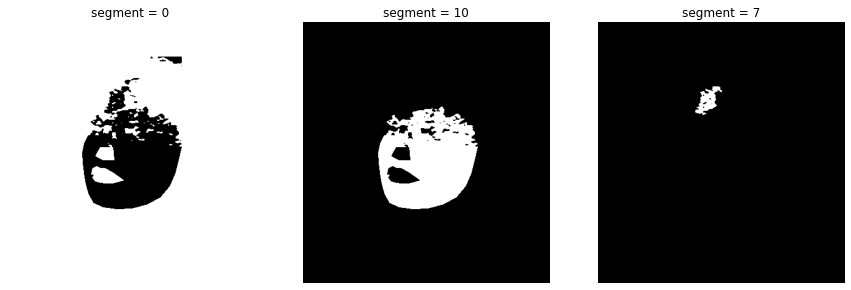

In [393]:
f, ax = plt.subplots(1,3, figsize=(15,5))
plot_img(labels==keys[0], title = f'segment = {keys[0]}', cmap = 'gray', ax = ax[0])
plot_img(labels==keys[1], title = f'segment = {keys[1]}', cmap = 'gray', ax = ax[1])
plot_img(labels==keys[2], title = f'segment = {keys[2]}', cmap = 'gray', ax = ax[2])

In [394]:
kernel = np.ones((5,5),np.uint8)

In [395]:
closing = cv2.morphologyEx(final_mask_unit8, cv2.MORPH_CLOSE, kernel)

In [396]:
dilation = cv2.dilate(final_mask_unit8,kernel,iterations = 1)

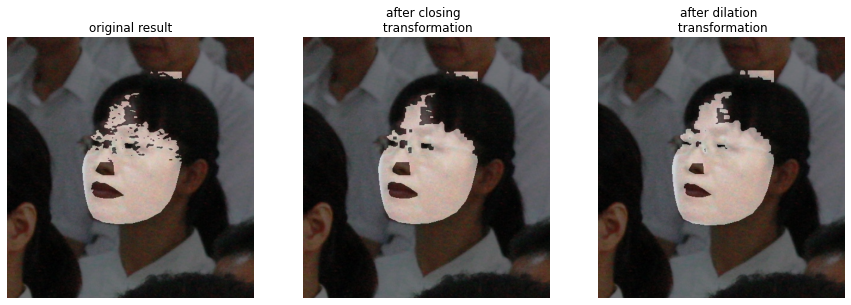

In [397]:
f, ax = plt.subplots(1,3, figsize=(15,5))

plot_img(img_RGB, ax = ax[0])
plot_img(final_mask, title = 'original result', alpha = 0.5, ax = ax[0])

plot_img(img_RGB, ax = ax[1])
plot_img(closing, title = 'after closing \n transformation', alpha = 0.5, ax = ax[1], cmap = 'gray')

plot_img(img_RGB, ax = ax[2])
plot_img(dilation, title = 'after dilation \n transformation',  alpha = 0.5, ax = ax[2], cmap = 'gray')

In [398]:
numLabels_closing, labels_closing, _, _ = cv2.connectedComponentsWithStats(closing)

In [399]:
# numLabels_closing has been reduced to 6! 
numLabels_closing

6

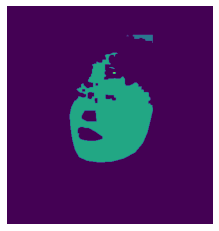

In [400]:
plot_img(labels_closing)

In [401]:
# Let's check how many pixels are inclueded in each segments in labels_closing:
segments_closing = dict(collections.Counter(labels_closing.flatten()))
segments_sorted_closing = dict(sorted(segments_closing.items(), key=lambda x:x[1], reverse = True))
keys_closing = list(segments_sorted_closing.keys())

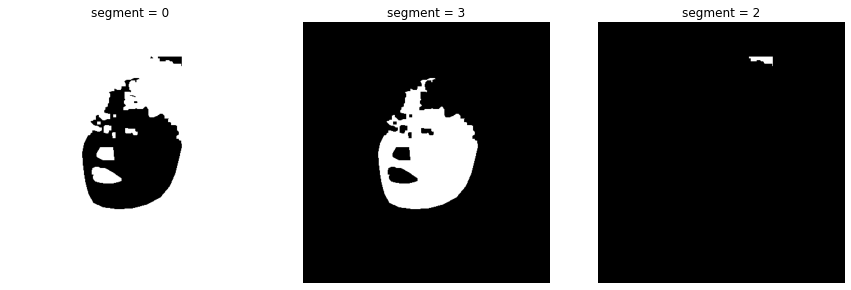

In [402]:
f, ax = plt.subplots(1,3, figsize=(15,5))
plot_img(labels_closing==keys_closing[0], title = f'segment = {keys_closing[0]}', cmap = 'gray', ax = ax[0])
plot_img(labels_closing==keys_closing[1], title = f'segment = {keys_closing[1]}', cmap = 'gray', ax = ax[1])
plot_img(labels_closing==keys_closing[2], title = f'segment = {keys_closing[2]}', cmap = 'gray', ax = ax[2])

Hence, the best results we get after morphological closing transformation and when we chose the bigest segment covered face.

In [403]:
#((keys_closing[1] == labels_closing) & (final_mask_unit8 == 255)).any()

In [404]:
def find_concave_contours(img, labels_closing, epsilon = 0.005, fill = False):

    contours, hierarchy = cv2.findContours(img, 1, 2)

    cnt = contours[0]
    max_area = cv2.contourArea(cnt)
    face_contour = np.zeros((*labels_closing.shape, 3), np.uint8)

    for contour in contours:
        if cv2.contourArea(contour) > max_area:
            cnt = contour
            max_area = cv2.contourArea(contour)

    perimeter = cv2.arcLength(cnt,True)
    eps = epsilon*cv2.arcLength(cnt,True)
    approx = cv2.approxPolyDP(cnt,eps,True)

    if fill:
        _ = cv2.fillPoly(face_contour, pts = [approx], color=(255,255,255)) 
    else:
        _ = cv2.drawContours(face_contour, [approx], -1, (255, 255, 255), 3)
    
    return face_contour

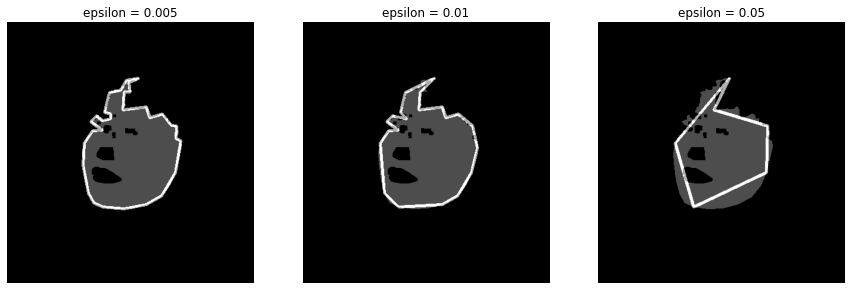

In [405]:
epsilons = [0.005, 0.01, 0.05]

f, ax = plt.subplots(1,3, figsize=(15,5))

for i in range(len(epsilons)):
    face_contour = find_concave_contours(np.uint8(labels_closing==keys_closing[1]), labels_closing, epsilon = epsilons[i])
    plot_img(labels_closing==keys_closing[1], title = f'epsilon = {epsilons[i]}', cmap = 'gray', ax = ax[i])
    plot_img(face_contour, alpha = 0.7, cmap = 'gray', ax = ax[i])

In [406]:
face_contour = find_concave_contours(np.uint8(labels_closing==keys_closing[1]), labels_closing, fill = True)

 what we know, is that img_mask (mask created using landmarks) is our "ground true", hence, we belive that all marked pixel as mask is really mask. What can be improved is pixel marked as [0,0,0] (no mask). Let's concatenate two masks - face_contour and img_mask

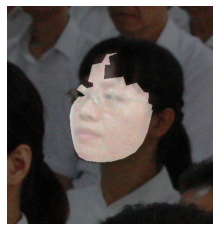

In [407]:
mask = np.where(img_mask == [0,0,0], face_contour, img_mask)
plot_img(img_RGB)
plot_img(mask, alpha = 0.5)

In [408]:
# all previous operations in one function
def improve_face_mask_using_morphology(final_mask, img_mask):
    final_mask_unit8 = np.uint8(final_mask[:,:,0])
    kernel = np.ones((5,5),np.uint8)
    closing = cv2.morphologyEx(final_mask_unit8, cv2.MORPH_CLOSE, kernel)
    numLabels_closing, labels_closing, _, _ = cv2.connectedComponentsWithStats(closing)
    # Let's check how many pixels are inclueded in each segments in labels_closing:
    segments_closing = dict(collections.Counter(labels_closing.flatten()))
    segments_sorted_closing = dict(sorted(segments_closing.items(), key=lambda x:x[1], reverse = True))
    keys_closing = list(segments_sorted_closing.keys())
    for i in keys_closing:
        covered_by_mask = ((i == labels_closing) & (final_mask_unit8 == 255)).any()
        if covered_by_mask:
            break
    face_contour = find_concave_contours(np.uint8(labels_closing==i), labels_closing, fill = True)
    mask = np.where(img_mask == [0,0,0], face_contour, img_mask)
    return mask

In [409]:
mask = improve_face_mask_using_morphology(final_mask, img_mask)

## improve mask is using Convexhull and tresholding

In [410]:
def mask_convex(mask):
    indx = np.where(mask==255)
    z = np.zeros((len(indx[0]),2))
    z[:,0] = indx[0]
    z[:,1] = indx[1]
    hull = ConvexHull(z)
    skin_mask_convex = np.zeros_like(mask) 
    skin_mask_convex = cv2.fillPoly(skin_mask_convex, pts =[z[hull.vertices][:,[1,0]].astype(int)], color=(255,255,255))
    return skin_mask_convex

In [411]:
skin_mask_convex = mask_convex(mask)

In [412]:
cutted_img = (skin_mask_convex/255).astype(int) * img_RGB

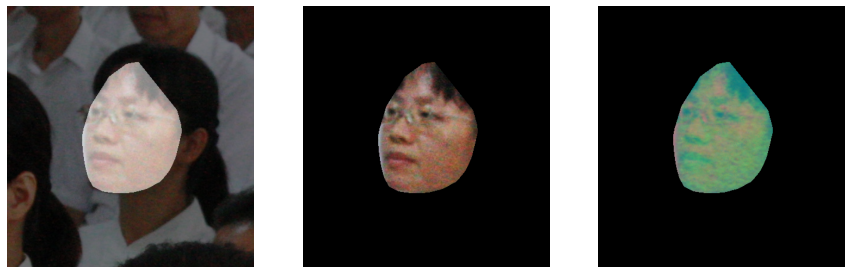

In [413]:
f, ax = plt.subplots(1,3, figsize=(15,5))
plot_img(img_RGB, ax = ax[0])
plot_img(skin_mask_convex, alpha = 0.5, ax = ax[0])
plot_img(cutted_img, ax = ax[1])
plot_img(cutted_img_YCrCb, ax = ax[2])

In [414]:
segments = slic(cutted_img, n_segments = 10, compactness=15, sigma = 3,  start_label = 1)

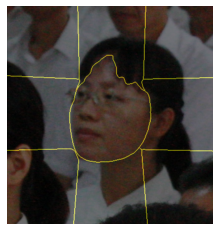

In [415]:
plot_img(img_RGB)
img_tmp = mark_boundaries(cutted_img, segments )
plot_img(img_tmp, alpha = 0.5) 

In [416]:
def find_segment_with_the_biggest_covered_area_by_mask(segments, mask):
    the_biggest_area_segment = {}
    improved_mask = np.zeros_like(mask)[:,:,0]
    for i in set(segments.flatten()):
        segments_area = (segments == i).sum()
        covered_by_mask_count_pixels = ((mask[:,:,0] == [255]) & (segments == i)).sum()
        the_biggest_area_segment[i] = covered_by_mask_count_pixels/segments_area
        
        if the_biggest_area_segment[i] > 0.5:
            improved_mask = np.where(improved_mask == 0, (segments == i).astype(int), improved_mask)

    return improved_mask

In [417]:
improved_mask =  find_segment_with_the_biggest_covered_area_by_mask(segments, skin_mask_convex)

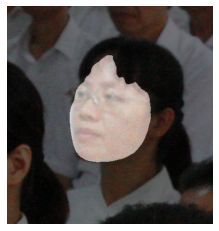

In [418]:
plot_img(img_RGB)
plot_img(improved_mask, alpha = 0.5, cmap = 'gray')

In this case the similar result we get if we ignore part with morph transformation:

In [419]:
skin_mask_convex = mask_convex(final_mask)
cutted_img = (skin_mask_convex/255).astype(int) * img_RGB
segments = slic(cutted_img, n_segments = 10, compactness=15, sigma = 3,  start_label = 1)
improved_mask =  find_segment_with_the_biggest_covered_area_by_mask(segments, skin_mask_convex)

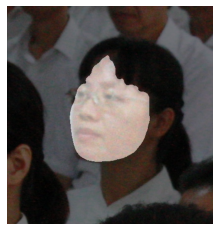

In [420]:
plot_img(img_RGB)
plot_img(improved_mask, alpha = 0.5, cmap = 'gray')

In [421]:
def mask_only_skin(mask, landmarks):
    img_mask = mask.copy()
    l_eye = np.take(landmarks(), landmarks.points_info['LEFT_EYE'], axis = 0)
    r_eye = np.take(landmarks(), landmarks.points_info['REIGHT_EYE'], axis = 0)

    nose = np.take(landmarks(), landmarks.points_info['NOSE_POINTS'], axis = 0)
    hull = ConvexHull(nose)
    nose = nose[hull.vertices]
    lips = np.take(landmarks(), landmarks.points_info['UPPER_LIP'] + landmarks.points_info['BOTTOM_LIP'], axis = 0)

    for i in [l_eye, r_eye , nose, lips]:
        cv2.fillPoly(img_mask, pts =[i], color=(0,0,0))  
    return img_mask

In [422]:
mask = mask_only_skin(improved_mask, landmarks)

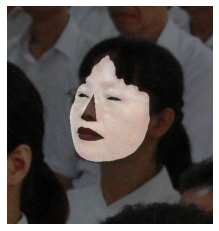

In [423]:
plot_img(img_RGB)
plot_img(mask, alpha = 0.5, cmap = 'gray')

## summary 

In [424]:
def find_skin_mask(img_BGR, morphology = True, only_skin = True, treshold_range_var = 10):
    img_RGB = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2RGB)
    img_mask, final_mask, img_YCrCb, landmarks = find_final_mask(img_BGR, treshold_range_var)
    if img_mask is not None:
        if morphology == True:
            final_mask = improve_face_mask_using_morphology(final_mask, img_mask)

        skin_mask_convex = mask_convex(final_mask)
        cutted_img = (skin_mask_convex/255).astype(int) * img_RGB
        segments = slic(cutted_img, n_segments = 10, compactness=15, sigma = 3,  start_label = 1)
        improved_mask =  find_segment_with_the_biggest_covered_area_by_mask(segments, skin_mask_convex)
        if only_skin == True:
            mask = mask_only_skin(improved_mask, landmarks)
        return mask
    return None

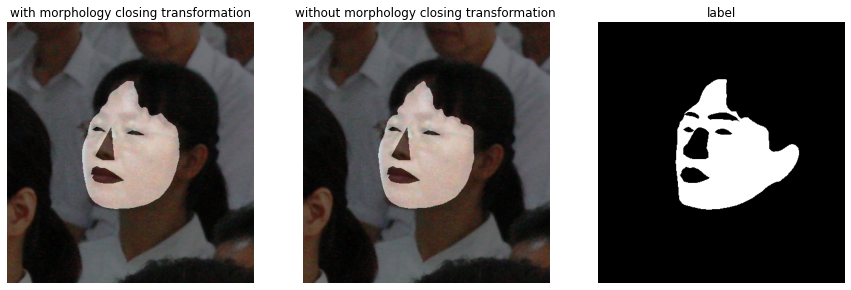

In [425]:
f, ax = plt.subplots(1,3, figsize=(15,5))

mask = find_skin_mask(img_BGR)
plot_img(img_RGB, ax = ax[0])
plot_img(mask, alpha = 0.5, cmap = 'gray', ax = ax[0], title = "with morphology closing transformation")

mask = find_skin_mask(img_BGR, morphology = False)
plot_img(img_RGB, ax = ax[1])
plot_img(mask, alpha = 0.5, cmap = 'gray', ax = ax[1], title = 'without morphology closing transformation')

plot_img((images_train[example_img]['labels'] == 1)[:,:,0].astype(int), ax = ax[2], cmap = 'gray', title = 'label')

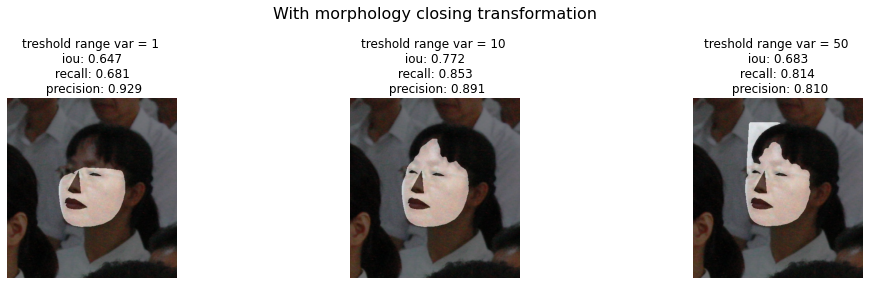

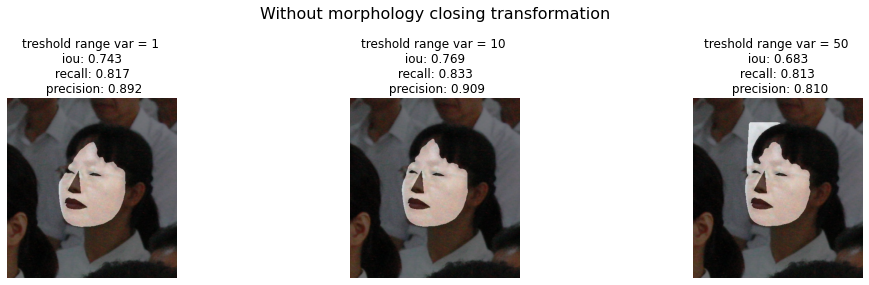

In [449]:
truth = (images_train[example_img]['labels'] == 1)[:,:,0]
treshold_range_vars = [1, 10, 50]
    
f, ax = plt.subplots(1,3, figsize=(15,4))
f.suptitle('With morphology closing transformation', fontsize=16)
for i in range(len(treshold_range_vars)):
    predicted = find_skin_mask(img_BGR, treshold_range_var = treshold_range_vars[i])
    iou_measure, recall_score_measure, precision_score_measure = measure(truth, predicted)
    title = f'treshold range var = {treshold_range_vars[i]} \n iou: {iou_measure :.3f} \n recall: {recall_score_measure :.3f} \n precision: {precision_score_measure :.3f}'
    plot_img(img_RGB, ax = ax[i])
    plot_img(predicted, alpha = 0.5, cmap = 'gray', ax = ax[i], title = title)
f.tight_layout()
    
    
f, ax = plt.subplots(1,3, figsize=(15,4))
f.suptitle('Without morphology closing transformation', fontsize=16)
for i in range(len(treshold_range_vars)):
    predicted = find_skin_mask(img_BGR, morphology = False, treshold_range_var = treshold_range_vars[i])
    iou_measure, recall_score_measure, precision_score_measure = measure(truth, predicted)
    title = f'treshold range var = {treshold_range_vars[i] } \n iou: {iou_measure :.3f} \n recall: {recall_score_measure :.3f} \n precision: {precision_score_measure :.3f}'
    plot_img(img_RGB, ax = ax[i])
    plot_img(predicted, alpha = 0.5, cmap = 'gray', ax = ax[i], title = title)
f.tight_layout()


In [429]:
example_img = list(images_train.keys())[4]
img_BGR = images_train[example_img]['img']
img_RGB = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2RGB)

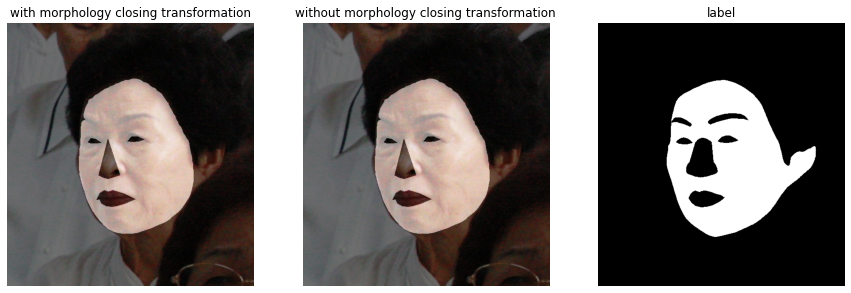

In [430]:
f, ax = plt.subplots(1,3, figsize=(15,5))

mask = find_skin_mask(img_BGR)
plot_img(img_RGB, ax = ax[0])
plot_img(mask, alpha = 0.5, cmap = 'gray', ax = ax[0], title = "with morphology closing transformation")

mask = find_skin_mask(img_BGR, morphology = False)
plot_img(img_RGB, ax = ax[1])
plot_img(mask, alpha = 0.5, cmap = 'gray', ax = ax[1], title = 'without morphology closing transformation')

plot_img((images_train[example_img]['labels'] == 1)[:,:,0].astype(int), ax = ax[2], cmap = 'gray', title = 'label')

In [476]:
def calculate_metrics_grid_search_var(images_train, treshold_range_vars):

    iou_measure_list = []
    recall_score_measure_list = []
    precision_score_measure_list = []
    example_img_list = []
    morphology_flag = []
    treshold_range_var_list = []
    
    for treshold_range_var in treshold_range_vars:
        for img in list(images_train.keys())[:]:

            img_BGR = images_train[img]['img']
            truth = (images_train[img]['labels'] == 1)[:,:,0]

            # with morphology
            mask = find_skin_mask(img_BGR, treshold_range_var = treshold_range_var)
            if mask is not None:
                predicted = mask
                iou_measure, recall_score_measure, precision_score_measure = measure(truth, predicted)
            else:
                iou_measure, recall_score_measure, precision_score_measure = None, None, None
            iou_measure_list.append(iou_measure)
            recall_score_measure_list.append(recall_score_measure)
            precision_score_measure_list.append(precision_score_measure)
            example_img_list.append(img)
            morphology_flag.append(True)
            treshold_range_var_list.append(treshold_range_var)


            # without morphology
            mask = find_skin_mask(img_BGR, morphology = False, treshold_range_var = treshold_range_var)
            predicted = mask
            if mask is not None:
                predicted = mask
                iou_measure, recall_score_measure, precision_score_measure = measure(truth, predicted)
            else:
                iou_measure, recall_score_measure, precision_score_measure = None, None, None        
            iou_measure_list.append(iou_measure)
            recall_score_measure_list.append(recall_score_measure)
            precision_score_measure_list.append(precision_score_measure)
            example_img_list.append(img)
            morphology_flag.append(False)
            treshold_range_var_list.append(treshold_range_var)


    
    d = {'iou' : iou_measure_list,
            'recall_scores' : recall_score_measure_list, 
            'precision_scores' : precision_score_measure_list ,
            'example_imgs' : example_img_list,
            'morphology': morphology_flag,
            'treshold_range_var': treshold_range_var_list}
    df = pd.DataFrame(data=d)

    
    return df

In [477]:
#df_results  = calculate_metrics_grid_search_var(images_train, treshold_range_vars = range(32))

In [481]:
#df_results.to_csv('results_skin_detection_with_landmarks.csv', index = False)

In [471]:
# To Do policzyc ile nanow 

In [478]:
df_results.head(5)

,iou,recall_scores,precision_scores,example_imgs,morphology,treshold_range_var
0,NaN,NaN,NaN,10001436895_0,True,0
1,NaN,NaN,NaN,10001436895_0,False,0
2,0.534852,0.575186,0.884088,10003645676_0,True,0
3,0.741850,0.958914,0.766205,10003645676_0,False,0
4,NaN,NaN,NaN,10004446093_1,True,0


In [482]:
df_results_to_show = df_results
df_results_to_show = df_results_to_show.dropna()
df_results_to_show.head(5)

,iou,recall_scores,precision_scores,example_imgs,morphology,treshold_range_var
2,0.534852,0.575186,0.884088,10003645676_0,True,0
3,0.741850,0.958914,0.766205,10003645676_0,False,0
8,0.348234,0.353960,0.955606,10004446093_2,True,0
9,0.832242,0.884124,0.934134,10004446093_2,False,0
10,0.606070,0.637369,0.925049,10004446093_3,True,0


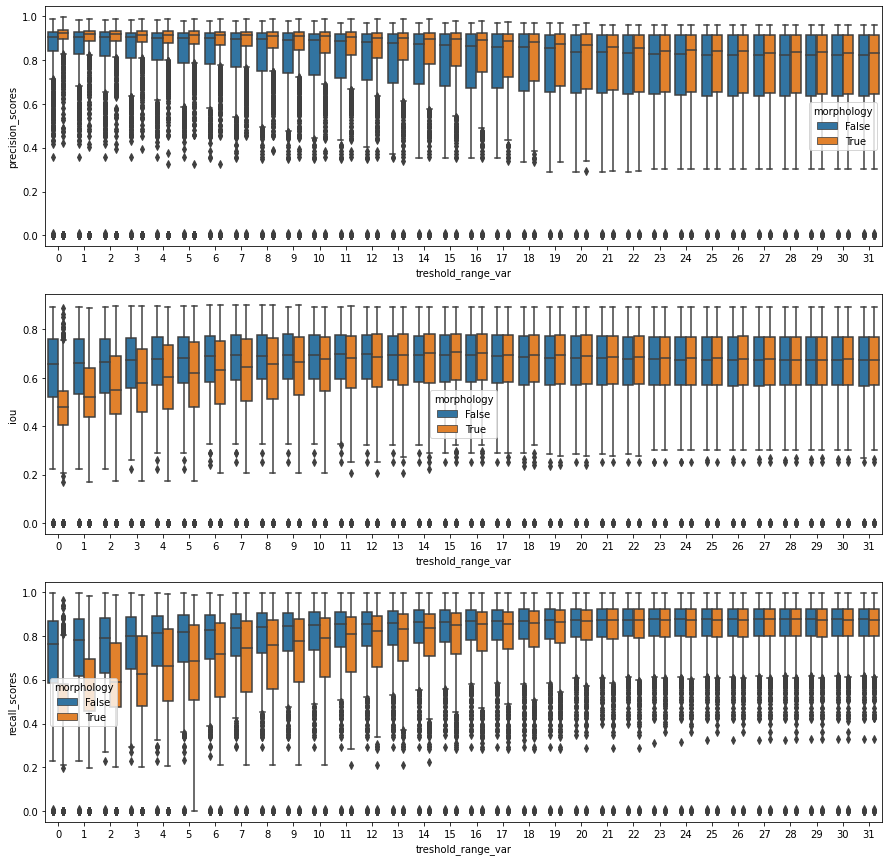

In [485]:
fig, ax = plt.subplots(3,1, figsize = (15,15))
_ = sns.boxplot(x="treshold_range_var", y="precision_scores", hue = 'morphology', data=df_results_to_show, ax = ax[0])
_ = sns.boxplot(x="treshold_range_var", y="iou",  hue = 'morphology', data=df_results_to_show, ax = ax[1])
_ = sns.boxplot(x="treshold_range_var", y="recall_scores",  hue = 'morphology', data=df_results_to_show, ax = ax[2])


In [489]:
df_results_to_show['iou'].min()

0.0